In [1]:
from itertools import product
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.utils.data as utils
from matplotlib import image as img
from matplotlib import pyplot as plt
import os
import pandas as pd

In [2]:
def train(net, X, y, optimizer, criterion, batch_size, lr, p=30):
    X = torch.Tensor(X).float()
    N = len(X)
    y = torch.Tensor(y).long()
    train_size = int(0.75 * N)
    valid_size = N - train_size
    train_index, valid_index = torch.utils.data.random_split(
        np.arange(N), [train_size, valid_size]
    )
    train_dataset = utils.TensorDataset(X[train_index], y[train_index])
    valid_dataset = utils.TensorDataset(X[valid_index], y[valid_index])
    dataloader = utils.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    validloader = utils.DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2
    )
    j = 0
    train_accs = []
    valid_accs = []
    train_losses = []
    valid_losses = []
    best_vloss = float("inf")
    while j < p:
        net.epoch += 1
        net.train()
        for batch in dataloader:
            optimizer.zero_grad()
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = criterion(net.forward(X), y)
            loss.backward()
            optimizer.step()

        net.eval()
        train_loss, train_acc = net.evaluate(dataloader, criterion)
        valid_loss, valid_acc = net.evaluate(validloader, criterion)

        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        if valid_loss < best_vloss:
            best_model = {
                "net": net.state_dict(),
                "epoch": net.epoch,
                "batch_size": batch_size,
                "lr": lr,
                "vacc": valid_acc,
                "vloss": valid_losses,
                "taccs": train_accs,
                "tloss": train_losses,
                "vaccs": valid_accs,
                "convs": net.conv_size,
                "lins": net.lin_size,
            }
            best_vloss = valid_loss
            best_net = net
            j = 0
        else:
            j += 1

        print("epoch: {}".format(net.epoch))
        print(" [LOSS] TRAIN {} / VALID {}".format(train_loss, valid_loss))
        print(" [ACC] TRAIN {} / VALID {}".format(train_acc, valid_acc))
    return best_model, net.epoch


def accuracy(y_pred, target):
    correct = torch.eq(y_pred.max(1)[1], target).sum().type(torch.FloatTensor)
    return correct / len(target)


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x


class Dropout(nn.Module):
    def __init__(self, p=0.3):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        data = x.data.cpu().numpy()
        shape = data.shape
        drop_idx = np.random.choice(
            np.arange(data.size), replace=False, size=int(data.size * self.p)
        )
        data = data.flatten()
        data[drop_idx] = 0
        data = data.reshape(shape)
        x.data = torch.from_numpy(data).cuda()
        return x


class Net(nn.Module):
    def __init__(self, input_size, conv_size, lin_size):
        super(Net, self).__init__()

        self.epoch = 0
        self.lin_size = lin_size
        self.conv_size = conv_size
        self.model = nn.Sequential(
            nn.Conv2d(input_size, conv_size, 3, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(conv_size, conv_size * 2, 3, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.Conv2d(conv_size * 2, conv_size * 4, 3, 1),
            nn.ReLU(True),
            nn.Conv2d(conv_size * 4, conv_size * 4, 3, 1),
            nn.MaxPool2d(3, 3),
            nn.ReLU(True),
            Flatten(),
            nn.Linear(conv_size * 3 * 3 * 4, lin_size),
            nn.ReLU(True),
            nn.Linear(lin_size, 2),
        ).cuda()

    def forward(self, x):
        return self.model(x)

    def evaluate(self, dataloader, criterion):
        LOSSES = 0
        ACCURACY = 0
        COUNTER = 0
        for batch in dataloader:
            X, y = batch
            X = X.view(-1, 3, 64, 64)
            y = y.view(-1)
            X = X.cuda()
            y = y.cuda()

            loss = criterion(self.forward(X), y)
            acc = accuracy(self.forward(X), y)
            n = y.size(0)
            LOSSES += loss.sum().data.cpu().numpy() * n
            ACCURACY += acc.sum().data.cpu().numpy() * n
            COUNTER += n

        floss = LOSSES / float(COUNTER)
        faccuracy = ACCURACY / float(COUNTER)
        return floss, faccuracy


def create_dataset(cats_path, dogs_path, test_path):
    train_set = []
    target = []
    n_cats = len(os.listdir(cats_path))
    for i in range(1, n_cats):
        f = '{}.Cat.jpg'.format(i)
        mat = img.imread(cats_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(0)

    n_dogs = len(os.listdir(dogs_path))
    for i in range(1, n_dogs):
        f = '{}.Dog.jpg'.format(i)
        mat = img.imread(dogs_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        train_set.append(mat)
        target.append(1)

    train_set = np.asarray(train_set)
    target = np.asarray(target)
    
    test_set = []
    n_test = len(os.listdir(test_path))
    for i in range(1, n_test):
        f = '{}.jpg'.format(i)
        mat = img.imread(test_path + f)
        if not len(mat.shape) == 3:
            mat = np.array((mat, mat, mat)).T
        test_set.append(mat)

    return train_set, target, np.asarray(test_set)

In [3]:
test_path = "/home/arthur/git/IFT6135_assignment_1/testset/test/"
dogs_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Dog/"
cats_path = "/home/arthur/git/IFT6135_assignment_1/trainset/Cat/"
X, y, submission = create_dataset(cats_path, dogs_path, test_path)
X = X / 255.0
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

In [4]:
net = Net(3, 128, 128)
par = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("The network contains {} parameters.".format(par))

The network contains 4428930 parameters.


In [5]:
batch_size = 64
learning_rate = 0.05

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
result, last_epoch = train(net, X, y, optimizer, criterion, batch_size, learning_rate)

epoch: 1
 [LOSS] TRAIN 0.692368120394757 / TEST 0.6922466187477112
 [ACC] TRAIN 0.5006251562890722 / TEST 0.4955
epoch: 2
 [LOSS] TRAIN 0.6902479968478782 / TEST 0.6886502184867859
 [ACC] TRAIN 0.5230682670071471 / TEST 0.5305
epoch: 3
 [LOSS] TRAIN 0.6892892788069998 / TEST 0.6874852304458619
 [ACC] TRAIN 0.5332583145786447 / TEST 0.542
epoch: 4
 [LOSS] TRAIN 0.6799233616754752 / TEST 0.6756905069351197
 [ACC] TRAIN 0.5728932233803509 / TEST 0.586
epoch: 5
 [LOSS] TRAIN 0.6753065459845692 / TEST 0.6715682382583619
 [ACC] TRAIN 0.5813328331337776 / TEST 0.5885
epoch: 6
 [LOSS] TRAIN 0.6785635311295313 / TEST 0.6758432726860046
 [ACC] TRAIN 0.566079019844368 / TEST 0.583
epoch: 7
 [LOSS] TRAIN 0.6698844760291187 / TEST 0.6675119881629944
 [ACC] TRAIN 0.5890847712971324 / TEST 0.5975
epoch: 8
 [LOSS] TRAIN 0.6711786734548084 / TEST 0.6713809461593628
 [ACC] TRAIN 0.5860215053018196 / TEST 0.588
epoch: 9
 [LOSS] TRAIN 0.6655590475932095 / TEST 0.6636971654891968
 [ACC] TRAIN 0.59721180302

epoch: 73
 [LOSS] TRAIN 0.0005453080945077617 / TEST 0.5156782606542111
 [ACC] TRAIN 0.9997499374843711 / TEST 0.9195
epoch: 74
 [LOSS] TRAIN 0.0005356402106699388 / TEST 0.5220778002738953
 [ACC] TRAIN 0.9997499374843711 / TEST 0.92
epoch: 75
 [LOSS] TRAIN 0.0005789438235173716 / TEST 0.5262951666116714
 [ACC] TRAIN 0.9997499374843711 / TEST 0.92
epoch: 76
 [LOSS] TRAIN 0.0005217231819335703 / TEST 0.5223987690210342
 [ACC] TRAIN 0.9997499374843711 / TEST 0.9205
epoch: 77
 [LOSS] TRAIN 0.0005383001984008333 / TEST 0.5298049367666244
 [ACC] TRAIN 0.9997499374843711 / TEST 0.9205
epoch: 78
 [LOSS] TRAIN 0.0005455816755575545 / TEST 0.5296673111915589
 [ACC] TRAIN 0.9997499374843711 / TEST 0.9205
epoch: 79
 [LOSS] TRAIN 0.0004962529128843094 / TEST 0.5328561539649963
 [ACC] TRAIN 0.9997499374843711 / TEST 0.9205
Best test accurcy is (0.4554547166824341, 0.9355)


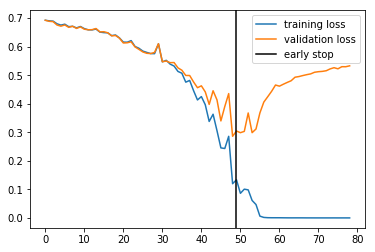

In [13]:
plt.plot(range(last_epoch), result["tloss"], label='training loss')
plt.plot(range(last_epoch), result["vloss"], label='validation loss')
plt.axvline(x=result['epoch'], label='early stop', color='black')
plt.legend()
plt.show()

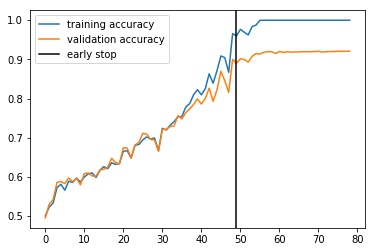

In [14]:
plt.plot(range(last_epoch), result["taccs"], label='training accuracy')
plt.plot(range(last_epoch), result["vaccs"], label='validation accuracy')
plt.axvline(x=result['epoch'], label='early stop', color='black')
plt.legend()
plt.show()

In [16]:
# net.load_state_dict(result['net'])
y = []
split = 10
step = int(len(submission) / split)
for i in range(0, len(submission), step):
    batch = torch.Tensor(submission[i : i + step])
    batch = batch.view(-1, 3, 64, 64)
    batch = batch.cuda()

    y += list(map(int, net.forward(batch).max(1)[1].cpu()))

y = pd.DataFrame(y)
y.index.name = "id"
y.columns = ["label"]
y = y.replace(0, "Cat")
y = y.replace(1, "Dog")
y.index += 1
y.to_csv("submission.csv")